In [6]:
#!wget -c https://raw.githubusercontent.com/jmarecek/OnlineLDS/master/inputlds.py
import sys
sys.path.append('C://Users//zhouq//Documents//OnlineLDS-master')
from inputlds import*

In [7]:
from ncpol2sdpa import*
import numpy as np
import math
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [75]:
# Set Parameters
level = 1
R=10
met=3
T = 20 
group = 2
trajectory = [2,3]
sum_traj = sum(trajectory)
ff=np.zeros([R,T*met])
g = np.matrix([[0.99,0],[1.0,0.2]])
f_dash = np.matrix([[1.1,0.8]])
proc_noise_std = np.random.rand(1,group)*0.1
obs_noise_std = np.random.rand(1,sum_traj)
inputs = np.zeros(T)
h0=[5,7]

In [76]:
# Generate observations of multiple trajectories 
Y_orig=np.mat(np.empty([T,sum_traj]))
j=0
for s in range(group):
    for i in range(trajectory[s]):
        ds1 = dynamical_system(g,np.zeros((2,1)),f_dash,np.zeros((1,1)),
        process_noise='gaussian',
        observation_noise='gaussian', 
        process_noise_std=proc_noise_std[0,s], 
        observation_noise_std=obs_noise_std[0,j])
        h1=np.ones(ds1.d)*h0[s]
        ds1.solve(h0=h1,inputs=inputs,T=T)
        Y_orig[:,j]=np.vstack(ds1.outputs)
        j+=1
            
# Write Y_orig data to csv files
pd.DataFrame(Y_orig).to_csv (r'FairOutput.csv', index = False, header=False)

In [77]:
Y_orig=pd.read_csv('FairOutput.csv',header=None)
Y_orig=Y_orig[0:20].to_numpy()

# Decision Variables
G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
p = generate_operators("p", n_vars=T, hermitian=True, commutative=True)
f = generate_operators("f", n_vars=T, hermitian=True, commutative=True)
# Constraints
ine1 = [f[i] - Fdash*m[i+1] - p[i] for i in range(T)]
ine2 = [-f[i] + Fdash*m[i+1] + p[i] for i in range(T)]
ine3 = [m[i+1] - G*m[i] - q[i] for i in range(T)]
ine4 = [-m[i+1] + G*m[i] + q[i] for i in range(T)]
ines_unfair = ine1+ine2+ine3+ine4
# Objective
obj_A = z + 1*sum(p[i]**2 for i in range(T)) # 1 is optimal for level 1
obj_B = z + 3*sum(p[i]**2 for i in range(T)) # 3 is optimal for level 1

# Solve
r=0
while r < R:
    # make varying length of multiple trajectories
    start=[0]+random.sample(range(0,10),trajectory[0]-1)+[0]+random.sample(range(0,5),trajectory[1]-1)
    end=random.sample(range(T-10,T),trajectory[0]-1)+[T]+random.sample(range(T-5,T),trajectory[1]-1)+[T]
    length=[end[i]-start[i] for i in range(sum_traj)]
    ind=np.zeros([T,sum_traj])
    for j in range(sum_traj):
        ind[start[j]:end[j],j]=1
    Y = np.multiply(Y_orig,ind)
    
    # Constraints
    max1 = [z-1/trajectory[0]*sum(1/length[j]*sum((Y[t,j]-f[t])**2 for t in range(start[j],end[j])) for j in range(0,trajectory[0]))]
    max2 = [z-1/trajectory[1]*sum(1/length[j]*sum((Y[t,j]-f[t])**2 for t in range(start[j],end[j])) for j in range(trajectory[0],sum_traj))]
    max3 = [z-(Y[t,j]-f[t])**2 for j in range(sum_traj) for t in range(start[j],end[j]) ]
    ines_A = ine1+ine2+ine3+ine4+max1+max2
    ines_B = ine1+ine2+ine3+ine4+max3
    
    # Objective
    obj_unfair = sum(sum((Y[t,j]-f[t])**2 for t in range(start[j],end[j])) for j in range(sum_traj)) + 5*sum(p[i]**2 for i in range(T)) # 5 is optimal for level 1
    
    # Solve the fair NCPO A
    sdp_A = SdpRelaxation(variables = flatten([G,Fdash,z,f,p,m,q]), verbose = 2)
    sdp_A.get_relaxation(level, objective=obj_A, inequalities=ines_A)
    sdp_A.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
    #print(sdp_A.primal, sdp_A.dual, sdp_A.status)
    
    # Solve the fair NCPO B
    sdp_B = SdpRelaxation(variables = flatten([G,Fdash,z,f,p,m,q]), verbose = 2)
    sdp_B.get_relaxation(level, objective=obj_B, inequalities=ines_B)
    #sdp.get_relaxation(level, objective=obj, inequalities=ines,substitutions=subs)
    sdp_B.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
    #print(sdp_B.primal, sdp_B.dual, sdp_B.status)
    
    # Solve the unfair NCPO
    sdp_unfair = SdpRelaxation(variables = flatten([G,Fdash,f,p,m,q]), verbose = 2)
    sdp_unfair.get_relaxation(level, objective=obj_unfair, inequalities=ines_unfair)
    sdp_unfair.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
    #print(sdp_unfair.primal, sdp_unfair.dual, sdp_unfair.status)

    # extract forecast
    # make sure all feasible
    if(sdp_A.status != 'infeasible' and sdp_B.status != 'infeasible' and sdp_unfair.status != 'infeasible'):
        ff_A=[sdp_A[f[i]] for i in range(T)]
        ff_B=[sdp_B[f[i]] for i in range(T)]
        unff=[sdp_unfair[f[i]] for i in range(T)]
        ff[r,:]=flatten([ff_A,ff_B,unff])
        r+=1



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 160/160 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 54/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 159/159 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 66/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 166/166 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 58/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 162/162 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 58/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 164/164 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 66/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 161/161 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 55/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 150/150 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 55/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 155/155 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 68/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 150/150 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 52/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 157/157 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 70/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 167/167 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 65/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 153/153 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 67/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 66/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2998 (done: 82.07%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 165/165 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 68/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 159/159 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 65/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 154/154 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 68/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 158/158 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 62/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 154/154 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 65/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 158/158 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 65/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 158/158 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 67/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 164/164 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 59/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 162/162 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 72/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 161/161 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 73/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 168/168 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 161/161 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 67/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 167/167 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 71/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2998 (done: 82.07%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 160/160 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 63/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 154/154 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 70/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 161/161 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 67/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 162/162 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 65/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 163/163 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 3000 (done: 84.09%, ETA 00:00:0.4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 158/158 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 68/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 159/159 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 70/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 151/151 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Reduced number of SDP variables: 3569569 (done: 100.03%, ETA 00:00:-0.0)
Processing 67/80 constraints...

Processing 80/80 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 2999 (done: 82.10%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 154/154 constraints...
The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 2999 (done: 84.06%, ETA 00:00:0.5)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Current number of SDP variables: 3339 (done: 91.41%, ETA 00:00:0.2)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The problem has 40 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3569
Generating moment matrix...
Current number of SDP variables: 3284 (done: 92.04%, ETA 00:00:0.2)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
# Write to files
ff=pd.DataFrame(ff)
ff.to_csv('CompareOutput_ff.csv',index=False,header=False)
outputs=open('CompareOutput_ff.txt','w')
print("proc_noise_std:",proc_noise_std,file=outputs)
print("obs_noise_std:",obs_noise_std,file=outputs)
print("Y_orig:",Y_orig,file=outputs)
outputs.close()

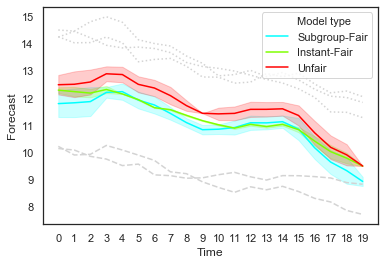

In [79]:
# Plot
ff=pd.read_csv('CompareOutput_ff.csv',header=None)
col1=ff.to_numpy().flatten() #values
col2=[t for t in range(T)]*met*R #time
col3=flatten([[m]*T for m in range(met)]*R) #type
df=pd.DataFrame(np.vstack((col1,col2,col3)).T,columns=['Forecast', 'Time', 'raw_type'])
df["Model type"] = df["raw_type"].astype("category")
df["Model type"].cat.categories = ["Subgroup-Fair", "Instant-Fair", "Unfair"]
df["Time"]=df["Time"].astype(int) 
df=df.drop(columns=['raw_type'])

sns.set(style="white",palette=["cyan","chartreuse","red"])
ax=sns.lineplot(x="Time",y="Forecast",hue="Model type",data=df,ci="sd")
ax=plt.xticks([i for i in range(T)])

ax=plt.plot(range(T),Y_orig[:,0],'y--',color="lightgrey")
ax=plt.plot(range(T),Y_orig[:,1],'y--',color="lightgrey")
ax=plt.plot(range(T),Y_orig[:,2],'y:',color="lightgrey")
ax=plt.plot(range(T),Y_orig[:,3],'y:',color="lightgrey")
ax=plt.plot(range(T),Y_orig[:,4],'y:',color="lightgrey")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.savefig('Overview.pdf', bbox_inches='tight') 